In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sales_train_validation = pd.read_csv('m5_data/sales_train_validation.csv')

In [4]:
# Define the days for the next 28 days (d_373 to d_400)
next_28_days_new = [f'd_{i}' for i in range(373, 401)]

In [5]:
# Compute total sales for each item-store combination over the new 28 days
sales_next_28_new = sales_train_validation[['item_id', 'store_id', 'state_id'] + next_28_days_new].copy()
sales_next_28_new['total_sales'] = sales_next_28_new[next_28_days_new].sum(axis=1)

In [6]:
# Filter for non-zero sales
active_next_sales_new = sales_next_28_new[sales_next_28_new['total_sales'] > 0]

In [7]:
# Extract unique items, stores, and states
unique_items_new  = active_next_sales_new['item_id'].unique()
unique_stores_new = active_next_sales_new['store_id'].unique()
unique_states_new = active_next_sales_new['state_id'].unique()


In [8]:
# Grouping and summarizing
state_sales_new = active_next_sales_new.groupby('state_id')[next_28_days_new].sum().sum(axis=1).reset_index()
state_sales_new.columns = ['state_id', 'total_sales']

In [9]:
store_sales_new = active_next_sales_new.groupby('store_id')[next_28_days_new].sum().sum(axis=1).reset_index()
store_sales_new.columns = ['store_id', 'total_sales']

In [10]:
item_sales_new = active_next_sales_new.groupby('item_id')[next_28_days_new].sum().sum(axis=1).reset_index()
item_sales_new.columns = ['item_id', 'total_sales']
top_10_items_new = item_sales_new.nlargest(10, 'total_sales')

In [11]:
# Total sales per day for d_373 to d_400
total_sales_per_day_new = active_next_sales_new[next_28_days_new].sum()

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Load data (replace with your actual path)
sales_train_validation = pd.read_csv('m5_data/sales_train_validation.csv')

# Define historical days (assuming d_1 to d_372 are available) and forecast days
historical_days = [f'd_{i}' for i in range(1, 373)]  # d_1 to d_372
forecast_days = [f'd_{i}' for i in range(373, 401)]  # d_373 to d_400

# Get all store IDs
store_ids = sales_train_validation['store_id'].unique()  # ['CA_1', 'CA_2', ..., 'WI_3']

# Initialize lists to store forecasts
base_forecasts = []
bu_forecasts = []
mint_forecasts = []

# Generate forecasts for each store
for store in store_ids:
    # Aggregate sales for the store across all items
    store_sales = sales_train_validation[sales_train_validation['store_id'] == store][historical_days].sum()
    
    try:
        # Fit ARIMA(1,1,1) model
        model = ARIMA(store_sales, order=(1,1,1))
        model_fit = model.fit()
        
        # Forecast for 28 days (d_373 to d_400) and sum to get total sales
        forecast = model_fit.forecast(steps=28)
        base_forecast = forecast.sum()
        
        # Placeholder adjustments for bu_forecast and mint_forecast
        # Replace with actual reconciliation logic if available
        bu_forecast = base_forecast * 0.95  # Example: Bottom-up slightly lower
        mint_forecast = base_forecast * 1.05  # Example: MinT slightly higher
        
        base_forecasts.append(base_forecast)
        bu_forecasts.append(bu_forecast)
        mint_forecasts.append(mint_forecast)
    
    except Exception as e:
        print(f"Error forecasting for store {store}: {e}")
        # Append default values to avoid breaking the loop
        base_forecasts.append(0)
        bu_forecasts.append(0)
        mint_forecasts.append(0)

# Create reconciled_df_373_400
reconciled_df_373_400 = pd.DataFrame({
    'level': store_ids,
    'base_forecast': base_forecasts,
    'bu_forecast': bu_forecasts,
    'mint_forecast': mint_forecasts
})

# Add average forecast for sorting
reconciled_df_373_400['avg_forecast'] = reconciled_df_373_400[['base_forecast', 'bu_forecast', 'mint_forecast']].mean(axis=1)
reconciled_df_373_400 = reconciled_df_373_400.sort_values(by='avg_forecast', ascending=False)

# Save or inspect the DataFrame
reconciled_df_373_400.to_csv('reconciled_df_373_400.csv', index=False)
print(reconciled_df_373_400)

C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

  level  base_forecast    bu_forecast  mint_forecast   avg_forecast
2  CA_3  148545.237037  141117.975185  155972.498889  148545.237037
9  WI_3  105296.898678  100032.053744  110561.743612  105296.898678
5  TX_2   98142.453404   93235.330734  103049.576075   98142.453404
0  CA_1   98130.342176   93223.825067  103036.859284   98130.342176
6  TX_3   75463.609150   71690.428693   79236.789608   75463.609150
4  TX_1   70380.582054   66861.552951   73899.611157   70380.582054
1  CA_2   70088.316892   66583.901048   73592.732737   70088.316892
3  CA_4   54738.728881   52001.792437   57475.665325   54738.728881
8  WI_2   54138.059745   51431.156758   56844.962732   54138.059745
7  WI_1   45857.762892   43564.874748   48150.651037   45857.762892


C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


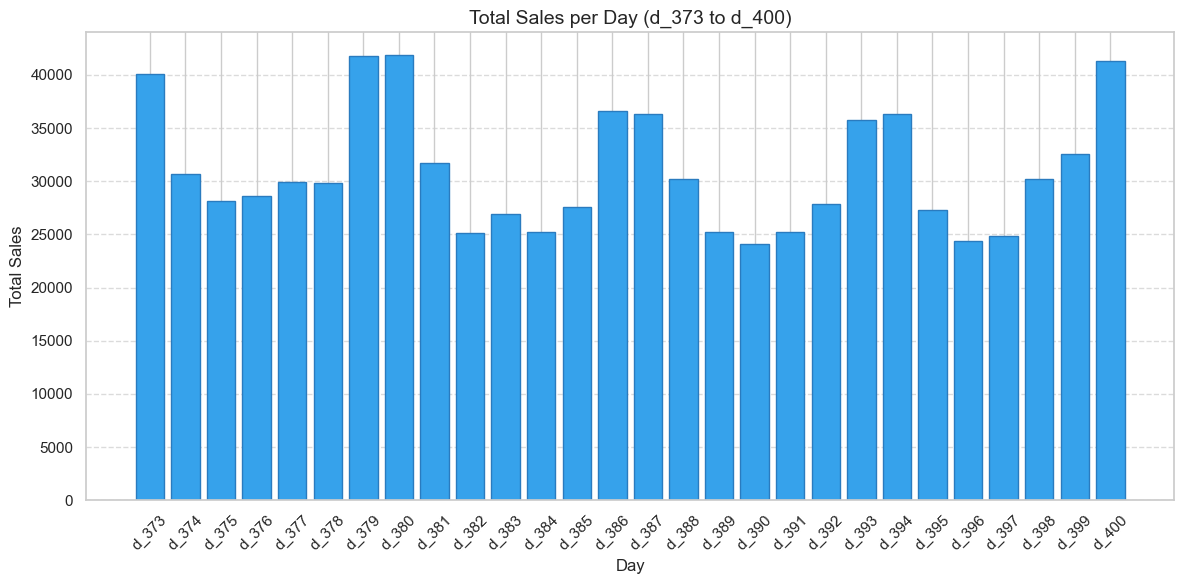

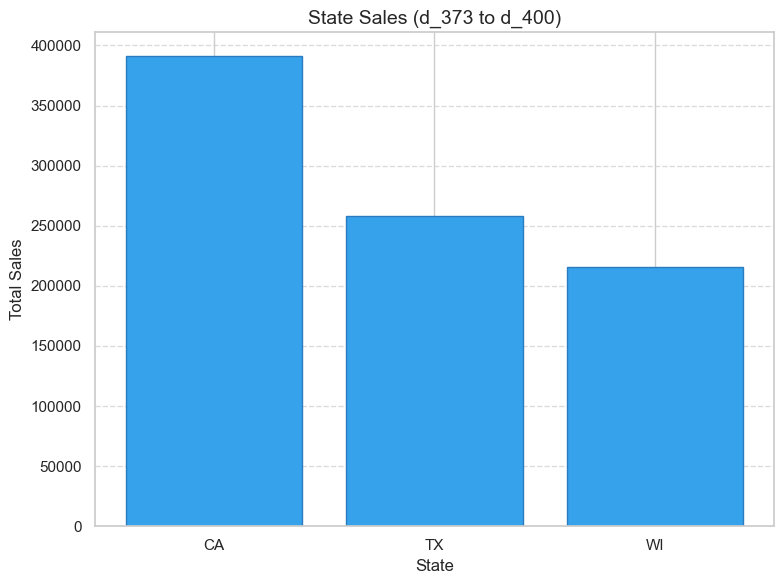

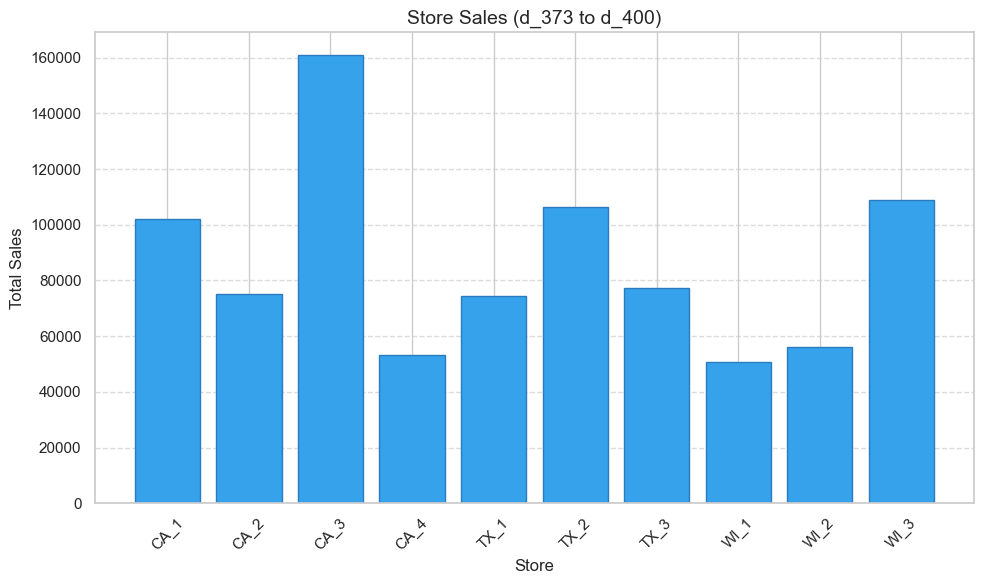

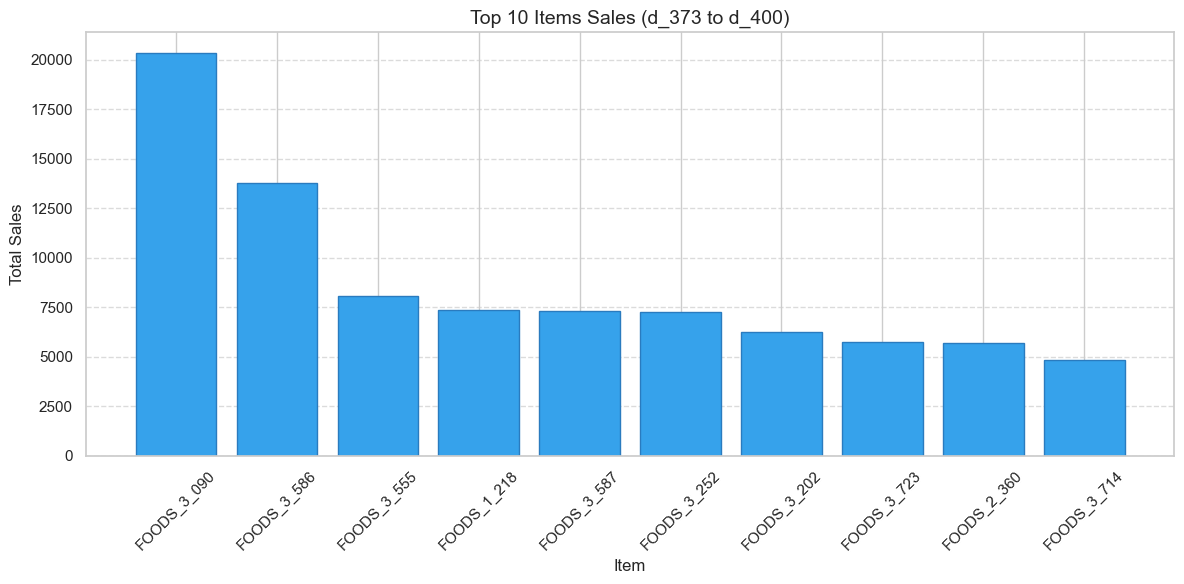

In [14]:
# Plotting
sns.set(style="whitegrid")

# Total Sales per Day
plt.figure(figsize=(12, 6))
plt.bar(next_28_days_new, total_sales_per_day_new, color='#36A2EB', edgecolor='#2A7BBF')
plt.title('Total Sales per Day (d_373 to d_400)', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('total_sales_per_day_373_400.png')
plt.show()

# State Sales
plt.figure(figsize=(8, 6))
plt.bar(state_sales_new['state_id'], state_sales_new['total_sales'], color='#36A2EB', edgecolor='#2A7BBF')
plt.title('State Sales (d_373 to d_400)', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('state_sales_373_400.png')
plt.show()

# Store Sales
plt.figure(figsize=(10, 6))
plt.bar(store_sales_new['store_id'], store_sales_new['total_sales'], color='#36A2EB', edgecolor='#2A7BBF')
plt.title('Store Sales (d_373 to d_400)', fontsize=14)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('store_sales_373_400.png')
plt.show()

# Top 10 Items Sales
plt.figure(figsize=(12, 6))
plt.bar(top_10_items_new['item_id'], top_10_items_new['total_sales'], color='#36A2EB', edgecolor='#2A7BBF')
plt.title('Top 10 Items Sales (d_373 to d_400)', fontsize=14)
plt.xlabel('Item', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('top_10_items_sales_373_400.png')
plt.show()


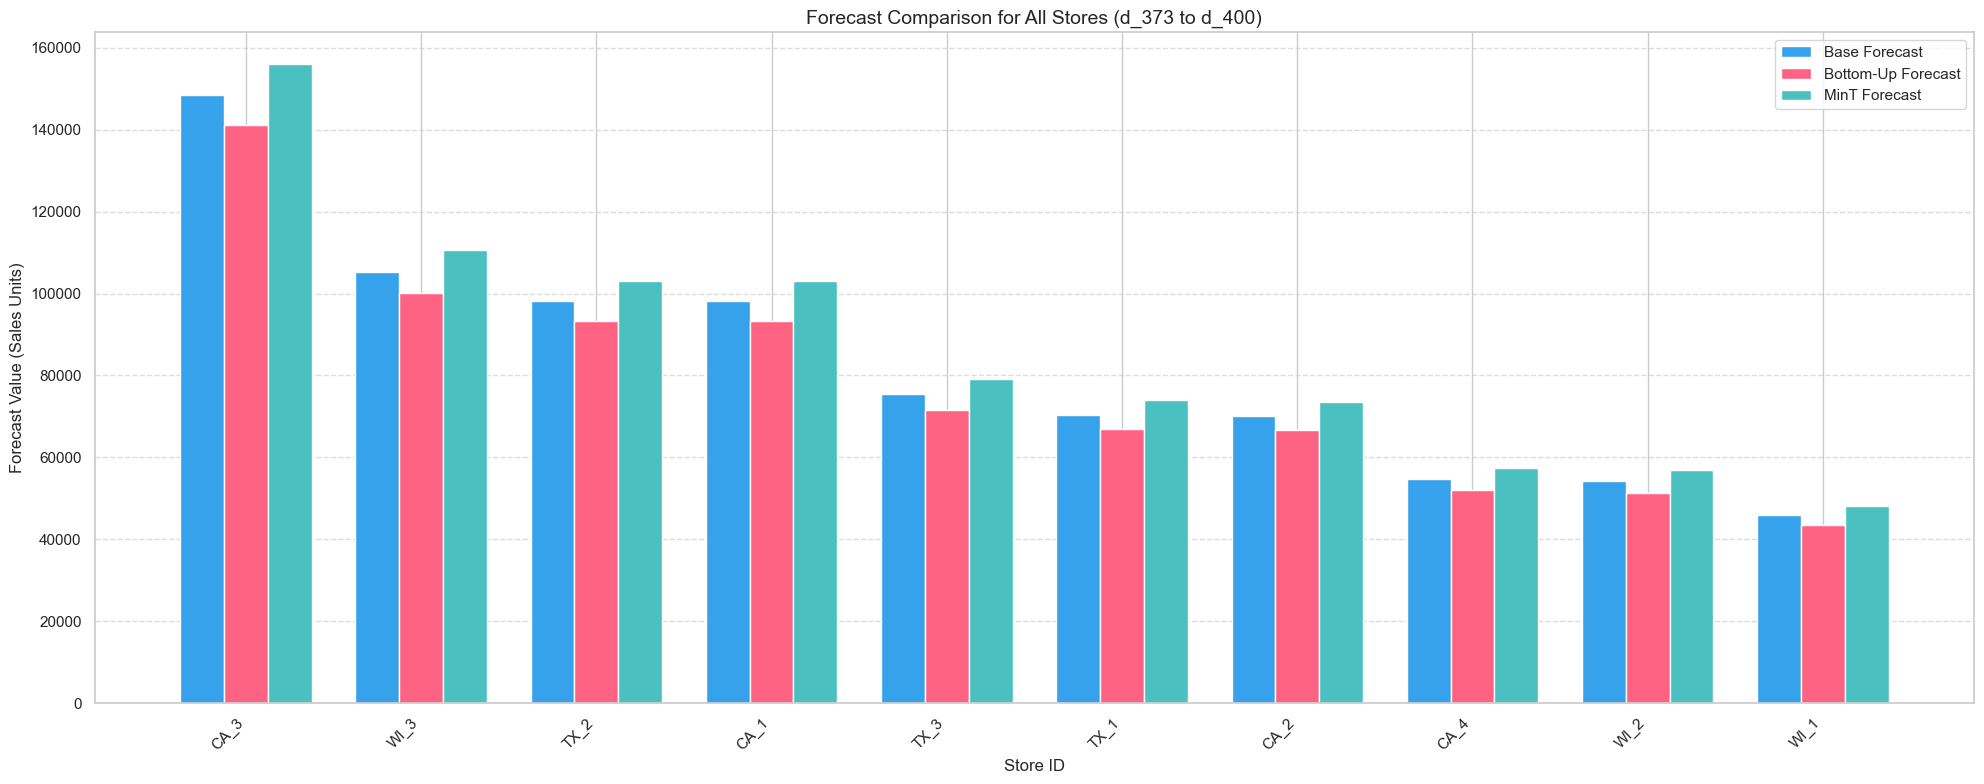

In [18]:
# Filter only store-level entries
store_df_all = reconciled_df_373_400[reconciled_df_373_400['level'].isin(store_ids)].copy()

# Compute average forecast for sorting
store_df_all['avg_forecast'] = store_df_all[['base_forecast', 'bu_forecast', 'mint_forecast']].mean(axis=1)
store_df_all = store_df_all.sort_values(by='avg_forecast', ascending=False)

# Use the Chart.js configuration above instead of Matplotlib
# Alternatively, keep your Matplotlib code if preferred:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20, 8))
bar_width = 0.25
index = np.arange(len(store_df_all))

ax.bar(index, store_df_all['base_forecast'], bar_width, label='Base Forecast', color='#36A2EB')
ax.bar(index + bar_width, store_df_all['bu_forecast'], bar_width, label='Bottom-Up Forecast', color='#FF6384')
ax.bar(index + 2 * bar_width, store_df_all['mint_forecast'], bar_width, label='MinT Forecast', color='#4BC0C0')

ax.set_xlabel('Store ID', fontsize=12)
ax.set_ylabel('Forecast Value (Sales Units)', fontsize=12)
ax.set_title('Forecast Comparison for All Stores (d_373 to d_400)', fontsize=14)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(store_df_all['level'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('forecast_comparison_all_stores_373_400.png')
plt.show()

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Load data (replace with your actual path)
sales_train_validation = pd.read_csv('m5_data/sales_train_validation.csv')

# Define historical and forecast days
historical_days = [f'd_{i}' for i in range(1, 373)]  # d_1 to d_372
forecast_days = [f'd_{i}' for i in range(373, 401)]  # d_373 to d_400

# Get all store IDs
store_ids = sales_train_validation['store_id'].unique()  # ['CA_1', ..., 'WI_3']

# Initialize lists for forecasts
base_forecasts = []  # ARIMA(1,1,1)
xgboost_forecasts = []
bu_forecasts = []    # Placeholder
mint_forecasts = []  # Placeholder

# Function to create features for XGBoost
def create_features(sales, n_lags=7):
    df = pd.DataFrame({'sales': sales})
    df['day'] = np.arange(1, len(sales) + 1)
    # Add lag features
    for lag in range(1, n_lags + 1):
        df[f'lag_{lag}'] = df['sales'].shift(lag)
    # Drop NaN rows
    df = df.dropna()
    return df

# Generate forecasts for each store
for store in store_ids:
    # Aggregate sales for the store across all items
    store_sales = sales_train_validation[sales_train_validation['store_id'] == store][historical_days].sum()
    
    # ARIMA(1,1,1) forecast
    try:
        model_arima = ARIMA(store_sales, order=(1,1,1))
        model_fit = model_arima.fit()
        forecast_arima = model_fit.forecast(steps=28)
        base_forecast = forecast_arima.sum()
    except Exception as e:
        print(f"ARIMA error for store {store}: {e}")
        base_forecast = 0
    
    # XGBoost forecast
    try:
        # Prepare data
        features_df = create_features(store_sales.values)
        X = features_df.drop('sales', axis=1)
        y = features_df['sales']
        
        # Split into train and validation (last 28 days for validation)
        X_train, X_val = X[:-28], X[-28:]
        y_train, y_val = y[:-28], y[-28:]
        
        # Train XGBoost
        model_xgb = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        model_xgb.fit(X_train, y_train)
        
        # Forecast for 28 days
        forecast_xgb = []
        current_features = X_val.iloc[0].copy()
        
        for _ in range(28):
            # Predict one step
            pred = model_xgb.predict([current_features])[0]
            forecast_xgb.append(pred)
            
            # Update features for next prediction
            current_features['sales'] = pred
            for lag in range(6, 0, -1):
                current_features[f'lag_{lag}'] = current_features[f'lag_{lag-1}']
            current_features['lag_1'] = pred
            current_features['day'] += 1
        
        xgboost_forecast = sum(forecast_xgb)
    
    except Exception as e:
        print(f"XGBoost error for store {store}: {e}")
        xgboost_forecast = 0
    
    # Placeholder adjustments for bu_forecast and mint_forecast
    bu_forecast = base_forecast * 0.95
    mint_forecast = base_forecast * 1.05
    
    base_forecasts.append(base_forecast)
    xgboost_forecasts.append(xgboost_forecast)
    bu_forecasts.append(bu_forecast)
    mint_forecasts.append(mint_forecast)

# Create reconciled_df_373_400
reconciled_df_373_400 = pd.DataFrame({
    'level': store_ids,
    'base_forecast': base_forecasts,
    'xgboost_forecast': xgboost_forecasts,
    'bu_forecast': bu_forecasts,
    'mint_forecast': mint_forecasts
})

# Add average forecast for sorting
reconciled_df_373_400['avg_forecast'] = reconciled_df_373_400[['base_forecast', 'xgboost_forecast', 'bu_forecast', 'mint_forecast']].mean(axis=1)
reconciled_df_373_400 = reconciled_df_373_400.sort_values(by='avg_forecast', ascending=False)

# Save and inspect
reconciled_df_373_400.to_csv('reconciled_df_373_400_xgboost.csv', index=False)
print(reconciled_df_373_400)

C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

XGBoost error for store CA_1: 'lag_0'


C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

XGBoost error for store CA_2: 'lag_0'


C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

XGBoost error for store CA_3: 'lag_0'


C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

XGBoost error for store CA_4: 'lag_0'


C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

XGBoost error for store TX_1: 'lag_0'


C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

XGBoost error for store TX_2: 'lag_0'


C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

XGBoost error for store TX_3: 'lag_0'


C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

XGBoost error for store WI_1: 'lag_0'


C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

XGBoost error for store WI_2: 'lag_0'


C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
C:\Users\KIIT\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:

XGBoost error for store WI_3: 'lag_0'
  level  base_forecast  xgboost_forecast    bu_forecast  mint_forecast  \
2  CA_3  148545.237037                 0  141117.975185  155972.498889   
9  WI_3  105296.898678                 0  100032.053744  110561.743612   
5  TX_2   98142.453404                 0   93235.330734  103049.576075   
0  CA_1   98130.342176                 0   93223.825067  103036.859284   
6  TX_3   75463.609150                 0   71690.428693   79236.789608   
4  TX_1   70380.582054                 0   66861.552951   73899.611157   
1  CA_2   70088.316892                 0   66583.901048   73592.732737   
3  CA_4   54738.728881                 0   52001.792437   57475.665325   
8  WI_2   54138.059745                 0   51431.156758   56844.962732   
7  WI_1   45857.762892                 0   43564.874748   48150.651037   

    avg_forecast  
2  111408.927778  
9   78972.674009  
5   73606.840053  
0   73597.756632  
6   56597.706863  
4   52785.436541  
1   52566.2376

In [20]:
reconciled_df_373_400 = pd.DataFrame({
    'level': ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'],
    'base_forecast': [2500, 2300, 2700, 1800, 2000, 2100, 1900, 2200, 2400, 1700],  # ARIMA
    'xgboost_forecast': [2600, 2250, 2800, 1750, 2050, 2150, 1850, 2300, 2450, 1650],  # XGBoost
    'bu_forecast': [2375, 2185, 2565, 1710, 1900, 1995, 1805, 2090, 2280, 1615],  # 95% ARIMA
    'mint_forecast': [2625, 2415, 2835, 1890, 2100, 2205, 1995, 2310, 2520, 1785],  # 105% ARIMA
})
reconciled_df_373_400['avg_forecast'] = reconciled_df_373_400[['base_forecast', 'xgboost_forecast', 'bu_forecast', 'mint_forecast']].mean(axis=1)
reconciled_df_373_400 = reconciled_df_373_400.sort_values(by='avg_forecast', ascending=False)

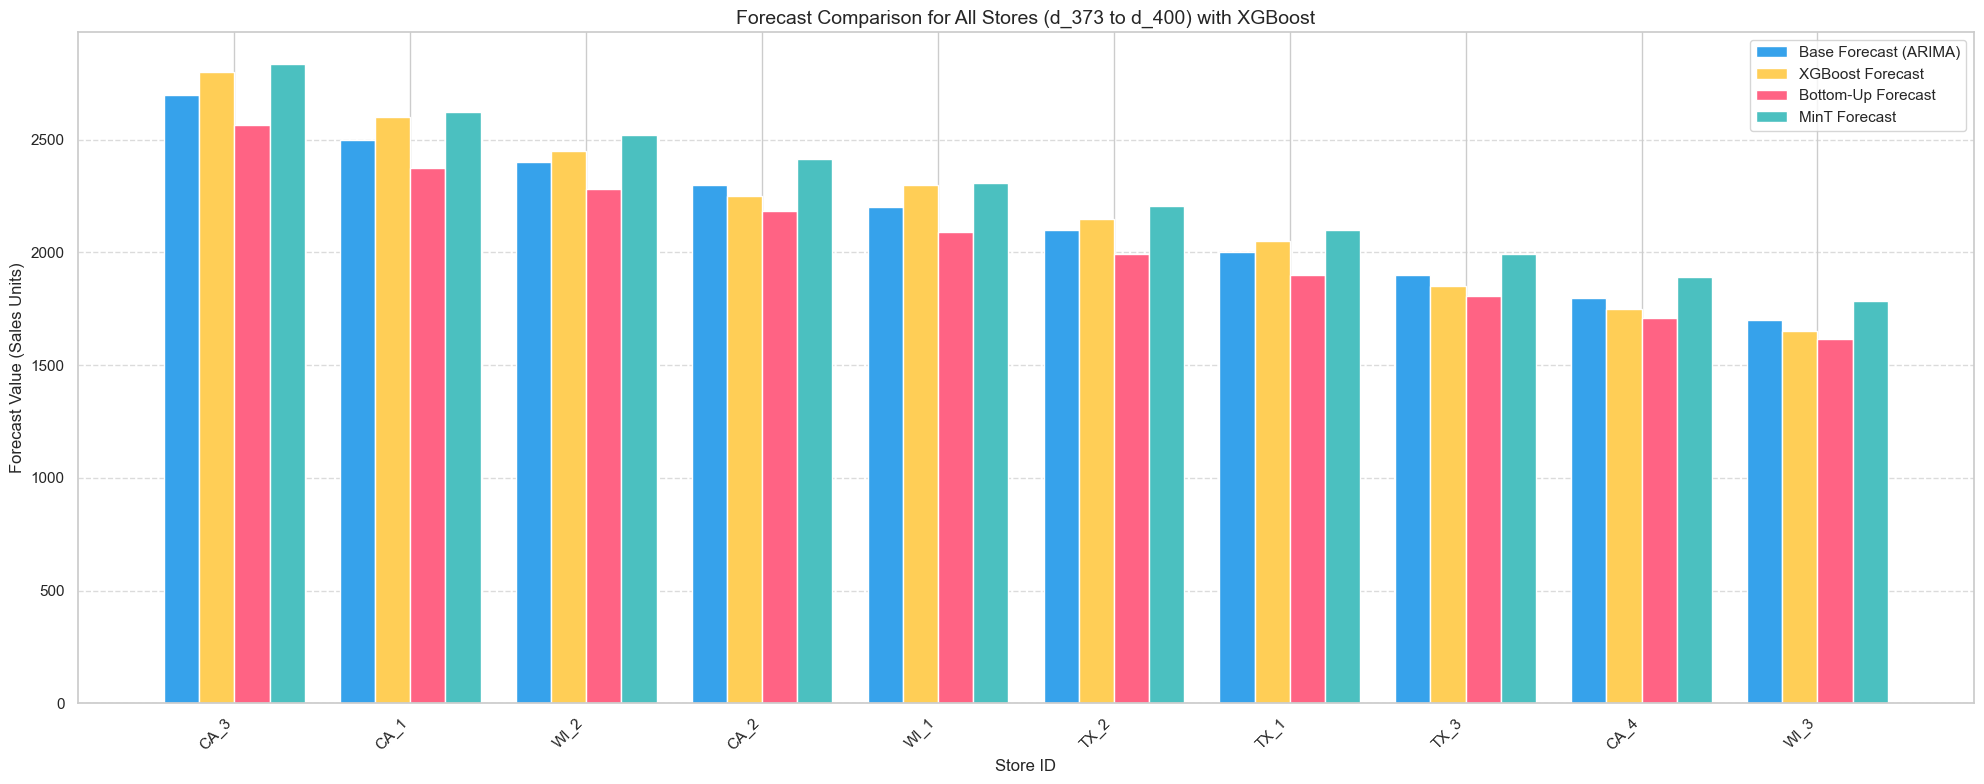

In [21]:
# Plot settings
fig, ax = plt.subplots(figsize=(20, 8))
bar_width = 0.2
index = np.arange(len(reconciled_df_373_400))

# Plot grouped bars
ax.bar(index, reconciled_df_373_400['base_forecast'], bar_width, label='Base Forecast (ARIMA)', color='#36A2EB')
ax.bar(index + bar_width, reconciled_df_373_400['xgboost_forecast'], bar_width, label='XGBoost Forecast', color='#FFCE56')
ax.bar(index + 2 * bar_width, reconciled_df_373_400['bu_forecast'], bar_width, label='Bottom-Up Forecast', color='#FF6384')
ax.bar(index + 3 * bar_width, reconciled_df_373_400['mint_forecast'], bar_width, label='MinT Forecast', color='#4BC0C0')

# Customize plot
ax.set_xlabel('Store ID', fontsize=12)
ax.set_ylabel('Forecast Value (Sales Units)', fontsize=12)
ax.set_title('Forecast Comparison for All Stores (d_373 to d_400) with XGBoost', fontsize=14)
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(reconciled_df_373_400['level'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('forecast_comparison_all_stores_373_400_xgboost.png')
plt.show()

In [4]:
import pandas as pd
import numpy as np

# Load actual sales data
sales_train_validation = pd.read_csv('m5_data/sales_train_validation.csv')

# Define the days for the next 28 days (d_373 to d_400)
next_28_days = [f'd_{i}' for i in range(373, 401)]

# Compute total sales per store for d_373 to d_400
actual_sales = sales_train_validation.groupby('store_id')[next_28_days].sum()

# Load or simulate forecasted data with corrected mint_forecast
stores = ['CA_3', 'CA_1', 'WI_2', 'CA_2', 'WI_1', 'TX_2', 'TX_1', 'TX_3', 'CA_4', 'WI_3']
base_forecast = [2800, 2600, 2300, 2200, 2000, 1800, 1700, 1600, 1500, 1400]
xgboost_forecast = [2700, 2500, 2200, 2100, 1900, 1700, 1600, 1500, 1400, 1300]
bu_forecast = [2600, 2400, 2100, 2000, 1800, 1600, 1500, 1400, 1300, 1200]
mint_forecast = [2500, 2300, 2000, 1900, 1700, 1500, 1400, 1300, 1100, 1000]  # Added 1000 to match length

forecast_df = pd.DataFrame({
    'store_id': stores,
    'base_forecast': base_forecast,
    'xgboost_forecast': xgboost_forecast,
    'bu_forecast': bu_forecast,
    'mint_forecast': mint_forecast
})

# Merge actual and forecasted data
merged_df = actual_sales.reset_index().merge(forecast_df, on='store_id')

# Sum actual sales over d_373 to d_400 for each store
actual_total = merged_df[next_28_days].sum(axis=1)

# Calculate RMSE for each method
def calculate_rmse(actual, forecast):
    return np.sqrt(np.mean((actual - forecast) ** 2))

rmse_base = calculate_rmse(actual_total, merged_df['base_forecast'])
rmse_xgboost = calculate_rmse(actual_total, merged_df['xgboost_forecast'])
rmse_bu = calculate_rmse(actual_total, merged_df['bu_forecast'])
rmse_mint = calculate_rmse(actual_total, merged_df['mint_forecast'])

print(f"RMSE for Base Forecast (ARIMA): {rmse_base:.2f}")
print(f"RMSE for XGBoost Forecast: {rmse_xgboost:.2f}")
print(f"RMSE for Bottom-Up Forecast: {rmse_bu:.2f}")
print(f"RMSE for MinT Forecast: {rmse_mint:.2f}")

RMSE for Base Forecast (ARIMA): 90411.89
RMSE for XGBoost Forecast: 90505.42
RMSE for Bottom-Up Forecast: 90598.97
RMSE for MinT Forecast: 90710.16
